# FMI Hirlam, MET Norway HARMONIE and NCEP GFS comparison demo

In this demo notebook we provide short comparison of using three different weather forecast models:
GFS -- http://data.planetos.com/datasets/noaa_gfs_pgrb2_global_forecast_recompute_0.25degree
HIRLAM -- http://data.planetos.com/datasets/fmi_hirlam_surface
HARMONIE -- http://data.planetos.com/datasets/metno_harmonie_metcoop

You can get more information about the datasets by opening links to their detail pages, but their main difference is that GFS is a global, medium range weather forecast model with lower resolution, and HIRLAM and HARMONIE are limited area models, meaning they cover only small part of the globe, but provide higher resolution of all forecasted field, in return.

First we compare the datasets by showing their spatial coverages, then we demonstrate their resolutions by showing forecast field as a discrete grid (so one can see the difference in grid cell size and resolved surface details) and finally we demonstrate plotting weather forecast for the same variable from three models. 

We try to keep this demo short, but in case you are interested in creating a more interactive notebook, please refer to our other examples:
https://github.com/planet-os/demos/blob/master/notebooks/PlanetOS_WAve_Models.ipynb
https://github.com/planet-os/notebooks/blob/master/api-examples/GFS_public_full_demo_main.ipynb

Unlike previous notebooks, we have moved most of the parsing code to external library dh_py_access, which you should get automatically if you get this notebook by cloning the git repository. 

If you have any questions, contact our team at https://data.planetos.com

At first, let's import some modules. If you do not have them, download them (ie. using pip or conda).

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import warnings
import dateutil.parser
import matplotlib
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import xarray as xr

Import datahub parsing library

In [2]:
from dh_py_access.lib.dataset import dataset as dataset
import dh_py_access.lib.datahub as datahub
from dh_py_access import package_api

Now we define hirlam and harmonie namespaces. Add server address and our API key. 
<font color='red'>Please add your API key below:</font>

In [3]:
server = 'http://api.planetos.com/v1/datasets/'
API_key = open('APIKEY').read().strip()

In [4]:
dh=datahub.datahub_main(API_key)
fmi_hirlam_surface=dataset('fmi_hirlam_surface',dh)
metno_harmonie_metcoop=dataset('metno_harmonie_metcoop',dh)
gfs=dataset('noaa_gfs_pgrb2_global_forecast_recompute_0.25degree',dh)

One can easily see what kind of variables are available in given dataset by just calling methods:

1. long_names -- gives a long human readable name for variable, which is unfortunately not standardised in any way
2. standard_names -- gives variable names as defined in CF convention standard name table http://cfconventions.org/standard-names.html
3. variable_names -- names by which you can actually query data from the API

on a given dataset instance.

In [5]:
sample_var_names = {fmi_hirlam_surface:'Temperature_height_above_ground',
                    metno_harmonie_metcoop:'air_temperature_2m',
                    gfs:'tmp_m'}

In [11]:
def get_max_coverage_package(dataset, area_name, varfilter = 'temp'):
    """Download full coverage for limited area datasets"""
    coords = dataset.get_dataset_boundaries()
    ds_west = np.amin([i[0] for i in coords])
    ds_east = np.amax([i[0] for i in coords])
    ds_south = np.amin([i[1] for i in coords])
    ds_north = np.amax([i[1] for i in coords])
    temperature_variable = sample_var_names[dataset]
    assert len(temperature_variable) >= 1, "something wrong {0}".format(temperature_variable)
    assert type(temperature_variable) == str
    return package_api.package_api(dh,dataset.datasetkey,temperature_variable,ds_west,ds_east,ds_south,ds_north,area_name=area_name)

In [7]:
area_name = 'maximum_04'

In [8]:
package_harmonie = get_max_coverage_package(metno_harmonie_metcoop, area_name=area_name)
package_fmi_hirlam = get_max_coverage_package(fmi_hirlam_surface, area_name=area_name)

In [9]:
package_harmonie.make_package()
package_fmi_hirlam.make_package()

Package exists
Package exists


In [10]:
package_harmonie.download_package()
package_fmi_hirlam.download_package()

File already downloaded
File already downloaded


In [12]:
data_harmonie = xr.open_dataset(package_harmonie.get_local_file_name())
data_fmi_hirlam = xr.open_dataset(package_fmi_hirlam.get_local_file_name(),decode_cf=False)

Take GFS for area of HARMONIE

In [13]:
left = np.amin(data_harmonie['lon'].data)
right = np.amax(data_harmonie['lon'].data)
bottom = np.amin(data_harmonie['lat'].data)
top = np.amax(data_harmonie['lat'].data)

package_gfs = package_api.package_api(dh,gfs.datasetkey,sample_var_names[gfs],left,right,bottom,top,area_name=area_name)
package_gfs.make_package()
package_gfs.download_package()

Package exists
File already downloaded


In [14]:
data_gfs = xr.open_dataset(package_gfs.get_local_file_name(),decode_cf=False)

## Dataset extent and resolution

Get some arbitrary field for demonstration, we use 2m temperature and as you can see, variable names may actually differ a lot between datasets. Please note that "get_tds_field" method is just for getting arbitrary preview image, if you wan't to query data for specific time and reftime, please refer to examples for our raster API (shown in other notebooks referenced to above) or use THREDDS server link given in dataset detail pages.

### Extent
The easiest way to show dataset extent is to plot it on a map with proper projection. We do not show GFS here, because, well, it is global.

In [16]:
m = Basemap(projection='ortho',lon_0=10,lat_0=50,resolution='l')

<IPython.core.display.Javascript object>


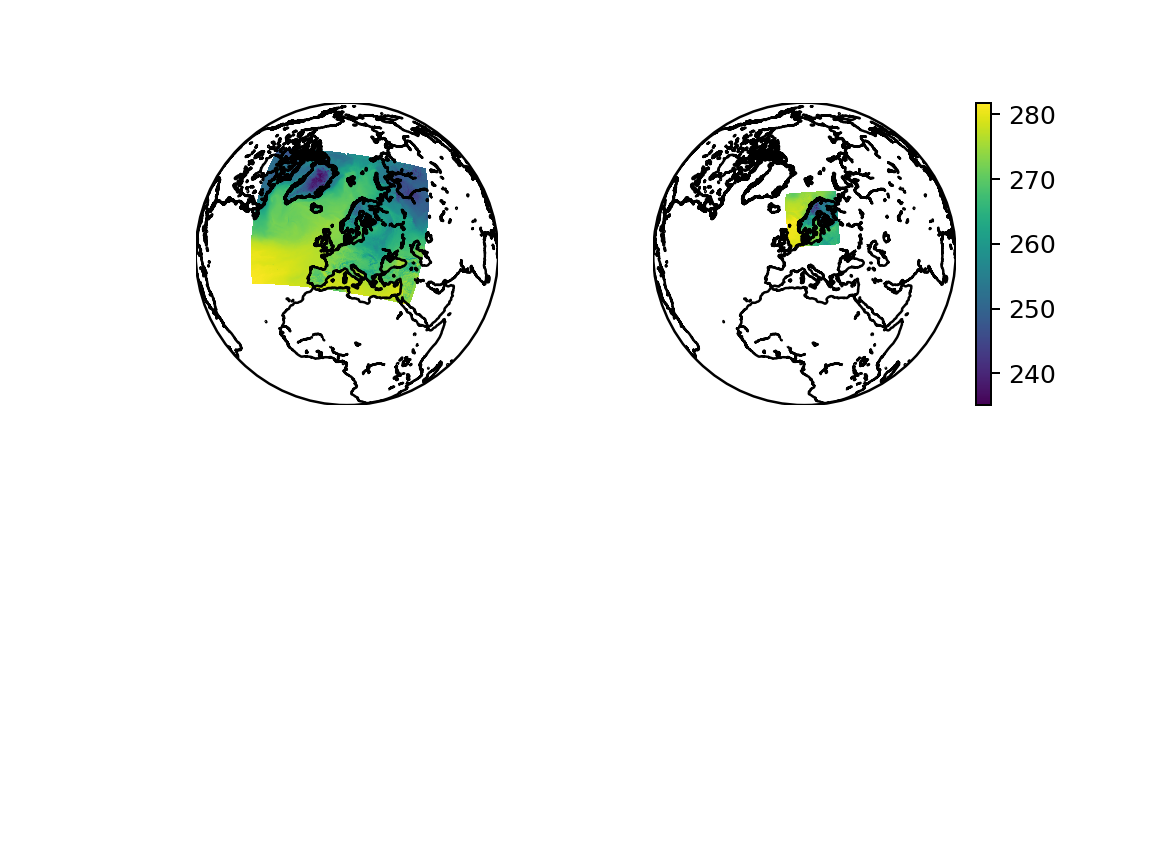

In [20]:
hir_x,hir_y=np.meshgrid(data_fmi_hirlam['lon'],data_fmi_hirlam['lat'])
X_hir,Y_hir=m(hir_x,hir_y)
fig=plt.figure()
plt.subplot(221)
air2d = data_fmi_hirlam[sample_var_names[fmi_hirlam_surface]][0,0,:,:]
air2d = np.ma.masked_where(air2d>500,air2d)
m.pcolormesh(X_hir,Y_hir,air2d)
m.drawcoastlines()
plt.subplot(222)
harm_x,harm_y=np.meshgrid(data_harmonie.lon,data_harmonie.lat)
X_harm,Y_harm=m(harm_x,harm_y)
m.pcolormesh(X_harm,Y_harm,data_harmonie[sample_var_names[metno_harmonie_metcoop]][0,0,:,:])
m.drawcoastlines()
plt.colorbar()

### Resolution 

Let's zoom in a little to illustrate difference in resolutions. By plotting the gridded data as a mesh, one can easily get the grid size from the figures. Plot's given for the Norwegian coast.

In [21]:
lon1,lon2=5,7
lat1,lat2 = 58,59

In [22]:
m2 = Basemap(projection='merc',llcrnrlat=lat1,urcrnrlat=lat2,\
            llcrnrlon=lon1,urcrnrlon=lon2,lat_ts=58,resolution='i')

<IPython.core.display.Javascript object>


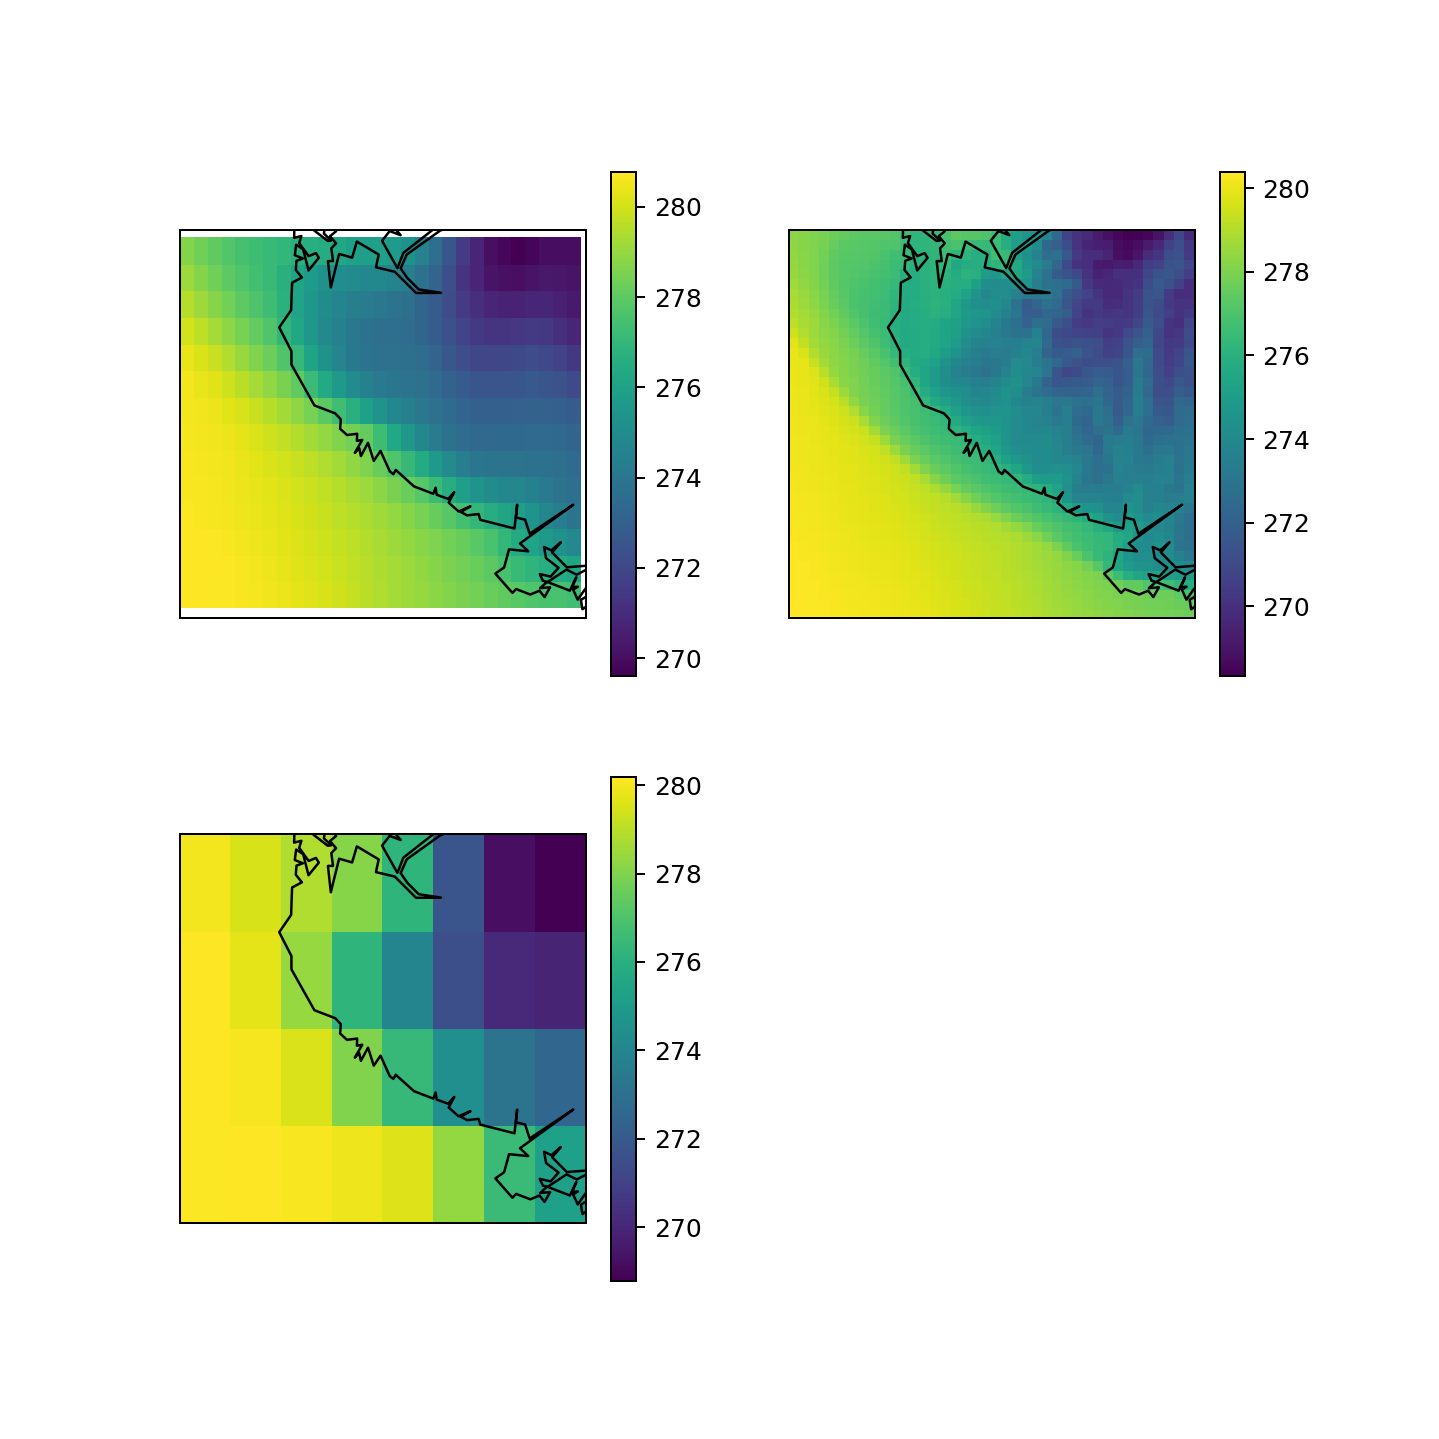

In [24]:
fig=plt.figure(figsize=(8,8))
plt.subplot(221)

## we cannot use .sel() method on hirlam data because 
##it was opened with decode_cf=False 
## which was because it contains both missing_value and fill_value, see https://github.com/pydata/xarray/issues/1749
x1 = np.argmin(np.abs(data_fmi_hirlam.lon-360-lon1)).data
x2 = np.argmin(np.abs(data_fmi_hirlam.lon-360-lon2)).data+1
y1 = np.argmin(np.abs(data_fmi_hirlam.lat-lat1)).data
y2 = np.argmin(np.abs(data_fmi_hirlam.lat-lat2)).data+1
height = int(np.argmin(np.abs(data_fmi_hirlam.height_above_ground-2)).data)
hir_x,hir_y=np.meshgrid(data_fmi_hirlam.lon[x1:x2].data,data_fmi_hirlam.lat[y1:y2].data)
X,Y=m2(hir_x-360,hir_y)
air2d_hirlam=data_fmi_hirlam.variables[sample_var_names[fmi_hirlam_surface]].isel(time=0,height_above_ground=height,lon=slice(x1,x2),lat=slice(y1,y2))
m2.pcolormesh(X,Y,air2d_hirlam)
m2.drawcoastlines()
plt.colorbar()

plt.subplot(222)
X,Y=m2(harm_x,harm_y)
air2d_harm = data_harmonie[sample_var_names[metno_harmonie_metcoop]].isel(time=0).sel(height1=2,lon=slice(lon1,lon2),lat=slice(lat1,lat2))
X,Y=m2(air2d_harm.lon.data,air2d_harm.lat.data)
m2.pcolormesh(X,Y,air2d_harm)
m2.drawcoastlines()
plt.colorbar()

plt.subplot(223)
ggg = data_gfs[sample_var_names[gfs]].isel(time1=0).sel(height_above_ground2=2,lon=slice(lon1,lon2),lat=slice(lat2,lat1))
x,y=np.meshgrid(ggg.lon,ggg.lat)
X,Y=m2(x,y)
m2.pcolormesh(X,Y,ggg)
m2.drawcoastlines()
plt.colorbar()

Can you guess which model is on which map by just looking at these images?

### Forecast for a single location
First, get point data for all datasets for given variable and for as long time range as the forecast goes.

In [25]:
longitude=26
latitude=58

In [26]:
sample_point_data = [(k,k.get_json_data_in_pandas(**{'var':v,'lon':longitude,'lat':latitude,'count':1000})) for k,v in sample_var_names.items()]

<IPython.core.display.Javascript object>


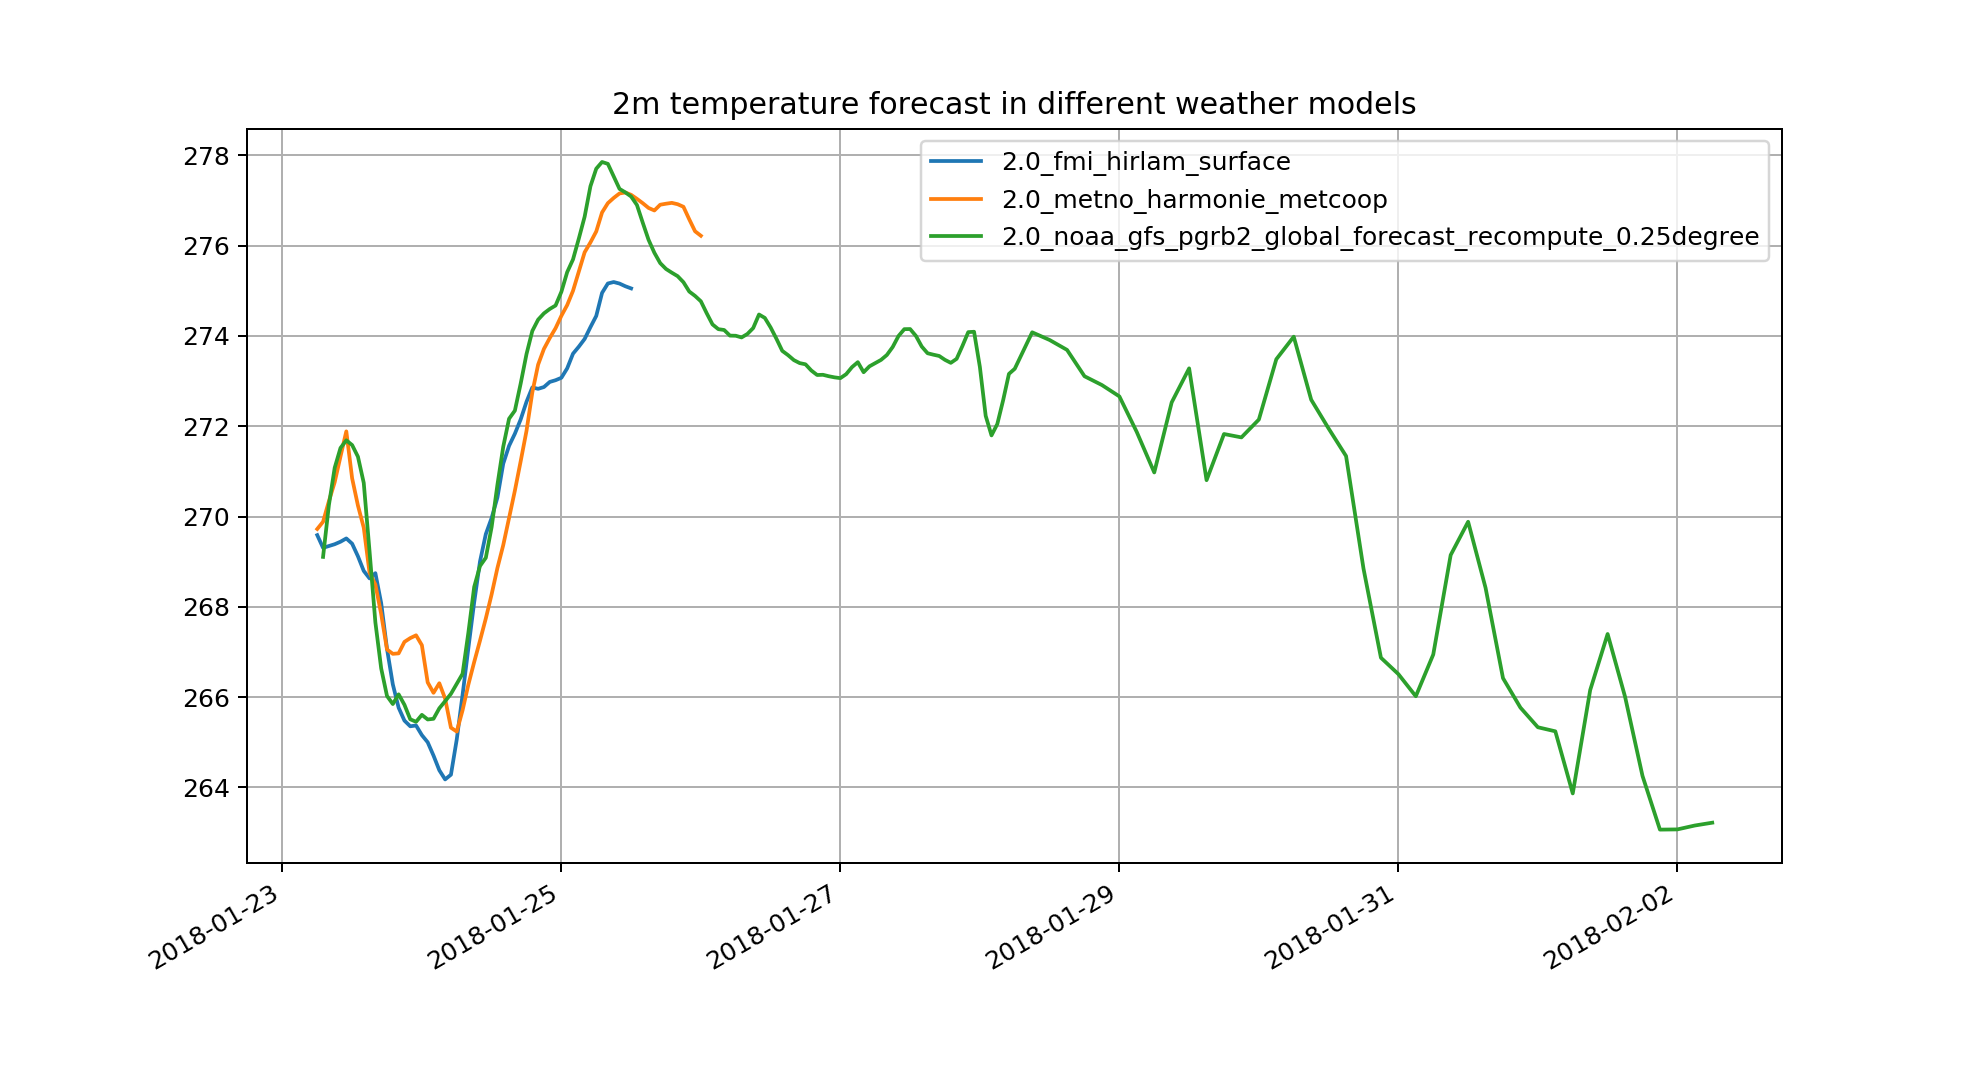

In [27]:
fig = plt.figure(figsize=(11,6))
for ddd in sample_point_data:
    zlevels = [2.]
    for i in zlevels:
        pdata=np.array(ddd[1][ddd[1]['z']==i][sample_var_names[ddd[0]]],dtype=np.float)
        if np.sum(np.isnan(pdata))!=pdata.shape[0]:
            plt.plot(ddd[1][ddd[1]['z']==i]['time'].apply(dateutil.parser.parse),pdata,label=str(i) + "_" + ddd[0].datasetkey)
plt.legend()
plt.grid()
fig.autofmt_xdate()
plt.title('2m temperature forecast in different weather models')
plt.show()